<a href="https://colab.research.google.com/github/tesfayeamare/Binarized-Neural-Networks-on-cifar10-and-Mnist-Dataset/blob/main/BNN_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## KERAS

In [ ]:
!pip uninstall tensorflow==2.8.0
!pip install tensorflow==2.7.0

### Import procedures

In [ ]:
import tensorflow.compat.v2 as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

import six
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import os
from PIL import Image

In [ ]:
# Check tfkeras and tf version
print('Tf Keras: {}'.format(tf.keras.__version__))
print('TensorFlow: {}'.format(tf.__version__))

Tf Keras: 2.7.0
TensorFlow: 2.7.0


### Download and verify data

11501568/11490434 [==============================] - 0s 0us/step


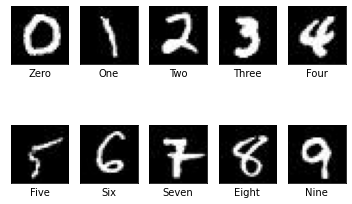

In [ ]:
# Load data from TF Keras
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


# MNIST class names
class_names = ['Zero', 'One', 'Two', 'Three', 'Four',
               'Five', 'Six', 'Seven', 'Eight', 'Nine']
num_classes = len(class_names)
path_images = "./images/"

# Create directory
if not os.path.exists(path_images):
    os.mkdir(path_images)

# Save one image per class 
ext=".jpg"
for image_index in range(0,100):
    im = Image.fromarray(x_test[image_index])
    im.save("./images/"+str(class_names[y_test[image_index]])+ext)    


# Show saved images

files = os.listdir(path_images)  
for img in files:
    if os.path.splitext(img)[1] == ext and os.path.splitext(img)[0] in class_names:
        #print(os.path.splitext(img)[0])
        plt.subplot(2,5,class_names.index(os.path.splitext(img)[0])+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(mpimg.imread(path_images+img),cmap='gray')
        plt.xlabel(os.path.splitext(img)[0])
plt.show()

### Pre process data

In [ ]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype(np.float32)/255
x_test = x_test.astype(np.float32)/255

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Print arrays shape
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
x_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)


In [ ]:
img_rows, img_cols = x_train.shape[1], x_train.shape[2] # input image dimensions
input_shape = (x_train.shape[1], x_train.shape[2], 1)

In [ ]:
# Full fp32 Keras model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation=tf.nn.relu,
                 input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation=tf.nn.relu))
model.add(Flatten())
model.add(Dense(num_classes, activation=tf.nn.softmax))

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
history = model.fit(x_train, y_train, epochs=3, batch_size=128, validation_data=(x_test, y_test), verbose=True)

Epoch 1/3
469/469 [==============================] - 127s 270ms/step - loss: 0.2042 - accuracy: 0.9413 - val_loss: 0.0640 - val_accuracy: 0.9817
Epoch 2/3
469/469 [==============================] - 99s 211ms/step - loss: 0.0606 - accuracy: 0.9818 - val_loss: 0.0515 - val_accuracy: 0.9836
Epoch 3/3
469/469 [==============================] - 94s 201ms/step - loss: 0.0416 - accuracy: 0.9870 - val_loss: 0.0447 - val_accuracy: 0.9856


In [ ]:
model.summary()
model.save("./cnnfp32_mnist.h5")
from google.colab import files
files.download("./cnnfp32_mnist.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 10)                184330    
                                                                 
Total params: 193,898
Trainable params: 193,898
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

313/313 - 4s - loss: 0.0447 - accuracy: 0.9856 - 4s/epoch - 14ms/step


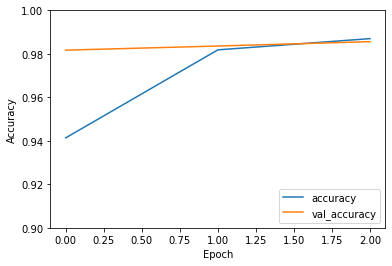

In [ ]:
# Evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.90, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

### Convert in tensorflow Lite model

In [ ]:
# Convert using integer-only quantization
# Now you have an integer quantized model that uses integer data for 
# the model's input and output tensors, so it's compatible with integer-only hardware

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] #converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model_quantInt = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpd98vv4zm/assets


In [ ]:
path_models = "./"
path_tflite_model = path_models+"quantInt_mnist.tflite"

# Save the quantized int model:
with open(path_tflite_model, 'wb') as f:
    f.write(tflite_model_quantInt)

from google.colab import files
files.download("./quantInt_mnist.tflite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Keras vs TFLite

In [ ]:
print(x_test.shape)
print(y_test.shape)

(10000, 28, 28, 1)
(10000, 10)


In [ ]:
from numpy.core.fromnumeric import argmax
from sklearn.metrics import accuracy_score
from tensorflow import keras

# model relative path
path_models = "./"
path_keras_model = path_models + "cnnfp32_mnist.h5" # path keras model
path_tflite_model = path_models + "quantInt_mnist.tflite" # path tensorflow quantized 8bit model

#print size of Keras and TFLite saved model
print("Keras model size: "+str(os.path.getsize(path_keras_model))+"Bytes")
print("TFlite model size: "+str(os.path.getsize(path_tflite_model))+"Bytes")
print("TFLite model is {:.2f}".format(os.path.getsize(path_keras_model)/os.path.getsize(path_tflite_model))+" times lower than Keras model")

#evaluate Keras model
model = keras.models.load_model(path_keras_model)

results = model.evaluate(x_test, y_test, batch_size=128, verbose=0)
print("\nKeras model accuracy score: " + str(results[1]))

#evaluate TFLite model
tflite_interpreter = tf.lite.Interpreter(model_path=path_tflite_model)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

tflite_interpreter.resize_tensor_input(input_details[0]['index'], (x_test[0:1000].shape))
tflite_interpreter.allocate_tensors()

#quantize
scale, zero_point = input_details[0]["quantization"]
x_test_lite = np.int8(x_test[0:1000] / scale + zero_point)

tflite_interpreter.set_tensor(input_details[0]['index'], x_test_lite)

tflite_interpreter.invoke()

scale, zero_point = output_details[0]['quantization']

tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])

#dequantize
#y_pred = (tflite_model_predictions.astype(np.float32) - zero_point) * scale

print("TFlite model accuracy score: "+str(accuracy_score(y_test.argmax(axis=1)[0:1000], tflite_model_predictions.argmax(axis=1))))

Keras model size: 2361912Bytes
TFlite model size: 198264Bytes
TFLite model is 11.91 times lower than Keras model

Keras model accuracy score: 0.9855999946594238
TFlite model accuracy score: 0.989


## QKERAS

In [ ]:
!pip install git+https://github.com/google/qkeras 

## This cell is to adapt input data to the Qkeras NN

In [ ]:
x_train = (x_train*255)-128
x_test = (x_test*255)-128

In [ ]:
# QKeras 1 and 8 bits model 

from qkeras import *

def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape)
    x = QActivation("quantized_bits(8, 7, alpha=1)", name="act_0")(x)   
    x = QConv2D(32, (3, 3),
        kernel_quantizer="quantized_bits(8, 7, alpha=1)", 
        use_bias = False,
        name="conv2d_1")(x)
    x = BatchNormalization()(x)
    x = QActivation("binary(alpha=1)", name="act_1")(x)
    x = QConv2D(32, (3, 3), 
        kernel_quantizer="binary(alpha=1)", 
        use_bias = False,
        name="conv2d_2")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)
    x = QActivation("binary(alpha=1)", name="act_2")(x)
    x = Flatten(name="flatten")(x)
    x = QDense(nb_classes,
        kernel_quantizer="binary(alpha=1)",
        bias_quantizer="binary(alpha=1)",
        name="dense")(x)
    x = Activation("softmax", name="softmax")(x)
    
    model = Model(inputs=x_in, outputs=x)
    
    return model

In [ ]:
qmodel = CreateQModel(x_train.shape[1:], y_train.shape[-1])
qmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 act_0 (QActivation)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (QConv2D)          (None, 26, 26, 32)        288       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 act_1 (QActivation)         (None, 26, 26, 32)        0         
                                                                 
 conv2d_2 (QConv2D)          (None, 24, 24, 32)        9216      
                                                             

In [ ]:
print_qstats(qmodel)

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.



Number of operations in model:
    conv2d_1                      : 194688 (smult_8_8)
    conv2d_2                      : 5308416 (sxor_1_1)
    dense                         : 46080 (sxor_1_1)

Number of operation types in model:
    smult_8_8                     : 194688
    sxor_1_1                      : 5354496

Weight profiling:
    conv2d_1_weights               : 288   (8-bit unit)
    conv2d_1_bias                  : 0     (32-bit unit)
    conv2d_2_weights               : 9216  (1-bit unit)
    conv2d_2_bias                  : 0     (32-bit unit)
    dense_weights                  : 46080 (1-bit unit)
    dense_bias                     : 10    (1-bit unit)
    ----------------------------------------
    Total Bits                     : 57610

Weight sparsity:
... quantizing model
  batch_normalization has not been quantized
  batch_normalization_1 has not been quantized
    conv2d_1                       : 0.6528
    conv2d_2                       : 0.0000
    dense        

In [ ]:
from tensorflow.keras.optimizers import Adam

qmodel.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(0.0005),
    metrics=["accuracy"])

In [ ]:
history = qmodel.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_test, y_test), verbose=True)

Epoch 1/20
469/469 [==============================] - 135s 285ms/step - loss: 102.9556 - accuracy: 0.1012 - val_loss: 94.5433 - val_accuracy: 0.1089
Epoch 2/20
469/469 [==============================] - 132s 281ms/step - loss: 86.1981 - accuracy: 0.1166 - val_loss: 81.3495 - val_accuracy: 0.1153
Epoch 3/20
469/469 [==============================] - 132s 281ms/step - loss: 75.6704 - accuracy: 0.1575 - val_loss: 73.0103 - val_accuracy: 0.1538
Epoch 4/20
469/469 [==============================] - 132s 281ms/step - loss: 66.6410 - accuracy: 0.2050 - val_loss: 79.9249 - val_accuracy: 0.1408
Epoch 5/20
469/469 [==============================] - 132s 281ms/step - loss: 46.1283 - accuracy: 0.3309 - val_loss: 39.2658 - val_accuracy: 0.4051
Epoch 6/20
469/469 [==============================] - 134s 285ms/step - loss: 28.8983 - accuracy: 0.5024 - val_loss: 37.0039 - val_accuracy: 0.4163
Epoch 7/20
469/469 [==============================] - 132s 282ms/step - loss: 19.8388 - accuracy: 0.6136 - val_

In [ ]:
scores = qmodel.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 8s 26ms/step - loss: 13.2035 - accuracy: 0.7097


In [ ]:
qmodel.save("./qkeras_mnist.h5")

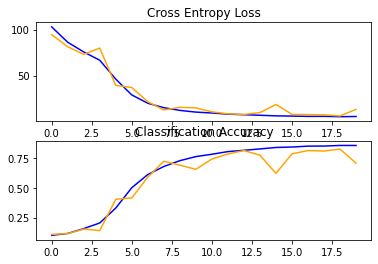

In [ ]:
# learning curves
# plot diagnostic learning curves
import sys
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

plt. show()

# save plot to file
filename = sys.argv[0].split('/')[-1]
pyplot.savefig(filename + '_plot.png')
pyplot.close()

In [ ]:
from google.colab import files
files.download("./qkeras_mnist.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Generation of validation samples: npz for XCUBEAI validation

In [ ]:
import numpy as np
# import qkeras
import tensorflow as tf
# import tensorflow.keras as keras

NUM_CLASSES = 10
SAMPLES = 100


(x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Adding channel dimension (1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

x_test = x_test.astype(np.float32)
x_test = x_test - 128
x_test = x_test.astype(np.int8)
y_test = y_test.astype(np.float32)
y_test = y_test - 128
y_test = y_test.astype(np.int8)
np.savez('qkeras_mnist_test.npz', in_0=x_test, out_0=y_test)
x_test_flattened = x_test.reshape((x_test.shape[0], -1))
y_test_flattened = y_test.reshape((y_test.shape[0], -1))
np.savetxt('qkeras_mnist_test_x.csv', x_test_flattened, delimiter=',')
np.savetxt('qkeras_mnist_test_y.csv', y_test_flattened, delimiter=',')
x_test_samples = x_test[:SAMPLES]
y_test_samples = y_test[:SAMPLES]
np.savez('qkeras_mnist_test_' + str(SAMPLES) + '.npz', in_0=x_test_samples, out_0=y_test_samples)
x_test_samples_flattened = x_test_samples.reshape((x_test_samples.shape[0], -1))
y_test_samples_flattened = y_test_samples.reshape((y_test_samples.shape[0], -1))
np.savetxt('qkeras_mnist_test_' + str(SAMPLES) + '_x.csv', x_test_samples_flattened, delimiter=',')
np.savetxt('qkeras_mnist_test_' + str(SAMPLES) + '_y.csv', y_test_samples_flattened, delimiter=',')

AttributeError: ignored